# Conclusion
There's nothing wrong with mintpy, 2*std isn't a good threshold for my data.

In [69]:
%matplotlib inline
from mintpy.utils import readfile
from mintpy import view
import matplotlib.pyplot as plt
from mintpy.objects import timeseries
from mintpy.timeseries2velocity import estimate_time_func
from datetime import datetime
import pandas as pd
import numpy as np

In [5]:
cd /home/fw/data/poroa_new

/home/fw/data/poroa_new


view.py velocity.h5 --noverbose


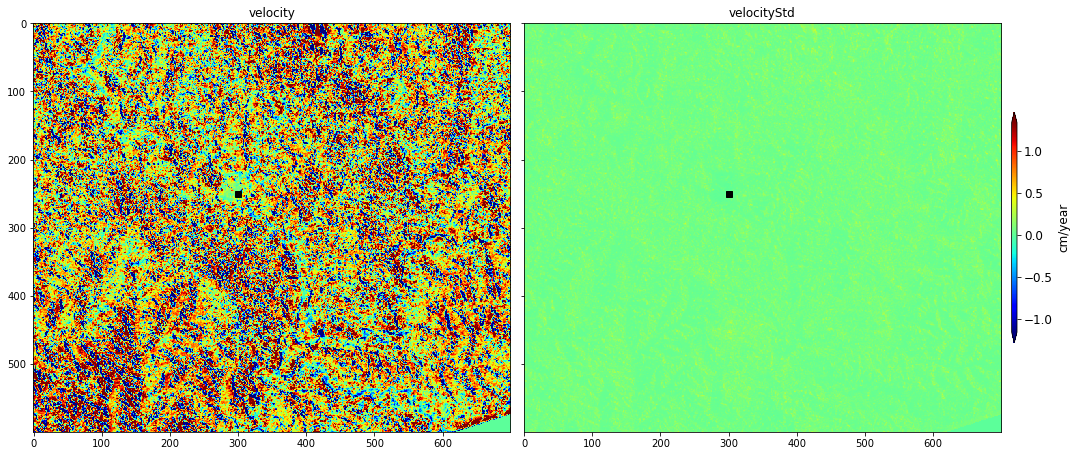

In [24]:
view.main('velocity.h5 --noverbose'.split())

In [26]:
poroa = {'x':421,'y':453,'v':-3.92}
river = {'x':427,'y':463,'v':-0.0766}

In [152]:
df = pd.DataFrame()
ts = timeseries('timeseries.h5')
dates = ts.get_date_list()
df['dates'] = [datetime.strptime(x,'%Y%m%d') for x in dates]
df['years'] = (df['dates'] - df['dates'].min()).dt.days / 365.25
# df['dYear'] = df['delta'].map(days) /365.25
# df['dates'] = pd.to_datetime(ts.get_date_list(),'%Y%m%d')

pbox = [poroa['x'],poroa['y'],poroa['x']+1,poroa['y']+1]
rbox = [river['x'],river['y'],river['x']+1,river['y']+1]
df['river'] = ts.read(box=rbox)
df['poroa'] = ts.read(box=pbox)

reading timeseries data from file: timeseries.h5 ...
reading timeseries data from file: timeseries.h5 ...


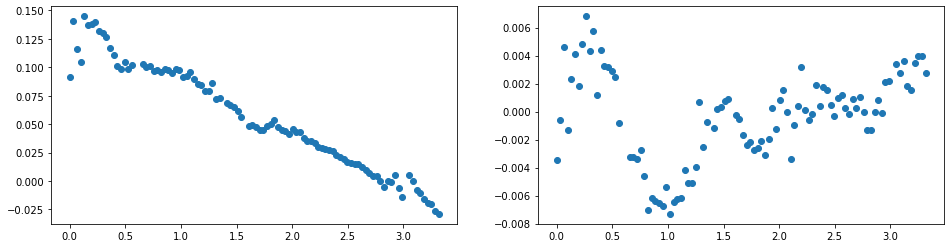

In [153]:
fig, [ax1,ax2] = plt.subplots(1,2,figsize=(16,4))
ax1.scatter(df['years'],df['poroa'])
ax2.scatter(df['years'],df['river'])
plt.show()

## Manual

In [148]:
A = np.vstack([df['years'], np.ones(df.shape[0])]).T
m, c = np.linalg.lstsq(A, df['poroa'], rcond=None)[0]
df['fitted line'] =  m*df['years'] + c

In [262]:
bootstrapCount = 500
runs = pd.DataFrame(columns=('m','c'),index=range(bootstrapCount))
for i in range(bootstrapCount):
    sample = df.sample(df.shape[0], replace=True).copy().sort_values('years').reset_index(drop=True)
    A = np.vstack([sample['years'], np.ones(sample.shape[0])]).T
    runs.iloc[i] = np.linalg.lstsq(A, sample['river'], rcond=None)[0]
    del sample,A

print(runs.m.mean(),runs.m.std())
print(0.0006974193383939564,0.00038516614586114883)
if abs(runs.m.mean()) > 2*runs.m.std():
    print('valid')
else:
    print('rejected')

0.0006378933197314706 0.0003696593232502542
0.0006974193383939564 0.00038516614586114883
rejected


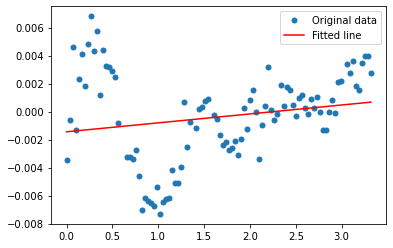

In [264]:
plt.plot(df['years'], df['river'], 'o', label='Original data', markersize=5)
plt.plot(df['years'], runs.m.mean()*df['years'] + runs.c.mean(), 'r', label='Fitted line')
plt.legend()
plt.show()

In [180]:
!subset.py timeseries.h5 -x 421 423 -y 453 455 -o timeseries_subset.h5

------------------------------
subset timeseries file: timeseries.h5 ...
data   range in (x0,y0,x1,y1): (0, 0, 700, 600)
subset range in (x0,y0,x1,y1): (421, 453, 423, 455)
data   range in (W, N, E, S): (385040.0, 5617200.0, 413040.0, 5593200.0)
subset range in (W, N, E, S): (401880.0, 5599080.0, 401960.0, 5599000.0)
writing >>> timeseries_subset.h5
update LENGTH, WIDTH, Y/XMAX
update/add SUBSET_XMIN/YMIN/XMAX/YMAX: 3921/5353/3923/5355
update Y/X_FIRST
update REF_Y/X
--------------------------------------------------
grab dataset structure from ref_file: timeseries.h5
create HDF5 file: timeseries_subset.h5 with w mode
create dataset  : bperp      of float32                   in size of (97,)                with compression = None
create dataset  : date       of |S8                       in size of (97,)                with compression = None
create dataset  : timeseries of float32                   in size of (97, 2, 2)           with compression = None
close  HDF5 file: timeseries_sub

In [187]:
# !timeseries2velocity.py timeseries_subset.h5 --bootstrap --bc 25 --poly 1 -o velocity_subset.h5
!timeseries2velocity.py timeseries.h5 --bootstrap --bc 25 --poly 1 -o velocity.h5

bootstrapping is turned ON.
open timeseries file: timeseries.h5
--------------------------------------------------
dates from input file: 97
['20171130', '20171212', '20171224', '20180105', '20180117', '20180129', '20180210', '20180222', '20180306', '20180318', '20180330', '20180411', '20180423', '20180505', '20180517', '20180529', '20180610', '20180622', '20180728', '20180809', '20180821', '20180902', '20180914', '20180926', '20181008', '20181020', '20181101', '20181113', '20181125', '20181207', '20181219', '20181231', '20190112', '20190124', '20190205', '20190217', '20190301', '20190313', '20190325', '20190406', '20190430', '20190512', '20190524', '20190605', '20190617', '20190711', '20190723', '20190804', '20190816', '20190828', '20190909', '20190921', '20191003', '20191015', '20191027', '20191108', '20191120', '20191202', '20191214', '20191226', '20200107', '20200119', '20200131', '20200212', '20200224', '20200307', '20200319', '20200331', '20200412', '20200424', '20200506', '20200

In [203]:
data = float(readfile.read('velocity.h5',box=rbox,datasetName='velocity')[0])
dataStd = float(readfile.read('velocity.h5',box=rbox,datasetName='velocityStd')[0])
print(data,dataStd)

0.0006974193383939564 0.00038516614586114883


In [213]:
!generate_mask.py velocity.h5 --vstd --vstd-num 5 -o stdMask.h5

input velocity file: velocity.h5
read velocity.h5
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels according to the formula: |velocity| > 5 * velocityStd
delete exsited file: stdMask.h5
create HDF5 file: stdMask.h5 with w mode
create dataset /mask of bool       in size of (600, 700)           with compression=None
finished writing to stdMask.h5
time used: 00 mins 0.1 secs.


view.py stdMask.h5 --noverbose


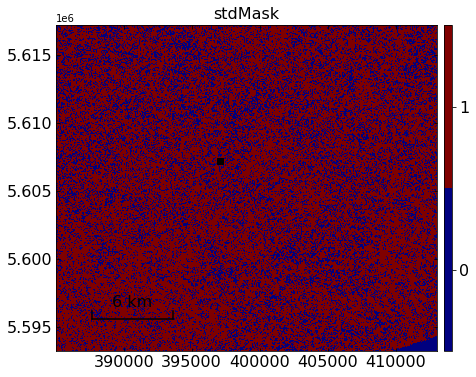

In [215]:
# %matplotlib widget
%matplotlib inline
import matplotlib.pyplot as plt
view.main('stdMask.h5 --noverbose'.split())

## Old

In [107]:
# ts_data = ts.read(box=[poroa['x'],poroa['y'],poroa['x']+1,poroa['y']+1])
# numDate = len(dates)
# ts_data = ts_data.reshape(numDate, -1)
# model = {'polynomial' : 1} 

# m = np.zeros((2, 4), dtype=np.float32)
# m_std = np.zeros((2, 4), dtype=np.float32)
# bootstrapCount = 25

# rng = np.random.default_rng()
# m_boot = np.zeros((bootstrapCount, 2, 4), dtype=np.float32)
# for i in range(bootstrapCount):
#     # bootstrap resampling
#     boot_ind = rng.choice(numDate, size=numDate, replace=True)
#     boot_ind.sort()
#     boot_dates = [dates[i] for i in boot_ind]

#     # estimation
#     m_boot[i] = estimate_time_func(model=model,date_list=boot_dates,dis_ts=ts_data[boot_ind])[1]

# m = m_boot.mean(axis=0).reshape(2, -1)
# m_std = m_boot.std(axis=0).reshape(2, -1)

reading timeseries data from file: timeseries.h5 ...
